In [41]:
import numpy as np
import pandas as pd
import requests
import time
from matplotlib import pyplot as plt
from pprint import pprint
from iso3166 import countries
import pymongo

# reading the income by country
# Then find the lastest income year and filter the data
# drop out duplicates country

In [3]:
df=pd.read_csv('annual_wages.csv')
df_1=df[['COUNTRY','Country','Time','Unit Code','Value']]
df_1.columns=['Country_code','Country','Year','Currency','Annual_income']
max=df_1['Year'].max()
income_df=df_1.loc[df_1['Year']==max]
income_df=income_df.drop_duplicates(subset=['Country'])


# API call to nominalise all the currency to USD by running first day/ last day of the year, then get the average (mean) exchange rate


In [4]:
rate=("https://api.exchangeratesapi.io/history?start_at=2019-01-01&end_at=2019-12-31&base=USD")
json = requests.get(rate).json()
rate_df=pd.DataFrame.from_dict(json['rates'])
avg_rate=rate_df.mean(axis=1)
avg_rate=avg_rate.to_frame()
avg_rate['Currency']=avg_rate.index
avg_rate.columns=['Rate','Currency']

# covert all the annual income to USD and save the FX rate  applied

In [5]:
income1_df=income_df.merge(avg_rate,on='Currency')
income1_df['income_USD']=income1_df['Annual_income']/income1_df['Rate']
#income1_df.drop(['Year','Annual_income','Rate'],axis=1)
income1_df

,Country_code,Country,Year,Currency,Annual_income,Rate,income_USD
0,AUS,Australia,2019,AUD,8.360248e+04,1.439273,58086.613623
1,AUT,Austria,2019,EUR,4.468883e+04,0.893409,50020.596455
2,BEL,Belgium,2019,EUR,4.724438e+04,0.893409,52881.047124
3,FIN,Finland,2019,EUR,4.261754e+04,0.893409,47702.181469
4,FRA,France,2019,EUR,3.909926e+04,0.893409,43764.140735
5,DEU,Germany,2019,EUR,4.242128e+04,0.893409,47482.503953
6,GRC,Greece,2019,EUR,1.758946e+04,0.893409,19688.039846
7,IRL,Ireland,2019,EUR,4.960502e+04,0.893409,55523.327202
8,ITA,Italy,2019,EUR,3.002826e+04,0.893409,33610.894799
9,LUX,Luxembourg,2019,EUR,6.584320e+04,0.893409,73698.861923


# Running the iso3166 conversion to get 2 digits country codes rather than 3 digits

In [6]:
alpha2=[]
for country in income1_df['Country_code']:
    country2=countries.get(country)
    alpha2.append(country2.alpha2)    
income1_df['alpha2']=alpha2


# Get the region from isthereanydeal API as there is 2 region in Europe called EU1/EU2

In [7]:
r_region=requests.get('https://api.isthereanydeal.com/v01/web/regions/')
region_df=pd.DataFrame.from_dict(r_region.json()['data'])
region=list(region_df.columns) 
eu1=pd.DataFrame.from_dict(r_region.json()['data']['eu1']['countries'])
eu2=pd.DataFrame.from_dict(r_region.json()['data']['eu2']['countries'])


In [8]:
#seperate Euro countries in 2 area as price has 2 EU region
for i in (eu1):
    eu1['region']="EU1"
    
for i in (eu2):
    eu2['region']="EU2"

eu_df=eu1.append(eu2)
eu_df.columns=['alpha2','eu_region']

In [9]:
income1_df=pd.merge(income1_df,eu_df, on='alpha2',how='left')

In [10]:
no=3
url = "https://api.isthereanydeal.com/v01/stats/popularity/chart/?"
key = "42c654a7eee83f02992f0317564462bceccdd585"
top_url = f"{url}key={key}&offset=0&&limit={no}"
response = requests.get(top_url).json()

In [11]:
top_df=pd.DataFrame.from_dict(response['data'])
top_df.drop(columns=['rank'])

,position,title,plain
0,1,NieR: Automata,nierautomata
1,2,Stardew Valley,stardewvalley
2,3,Divinity: Original Sin 2 - Definitive Edition,divinityoriginalsiniidefinitiveedition


In [12]:
price_df=pd.DataFrame()
currency_list=[]
region_list=[]
game_list=[]
session = requests.Session()

for index in top_df.plain:
    for i in region:
        url_2="https://api.isthereanydeal.com/v01/game/prices/?"
        price_url=f"{url_2}key={key}&plains={index}&shops=steam&region={i}"
        response_1 = requests.get(price_url).json()        
        price_dict=response_1['data']
        currency_list.append(response_1['.meta']['currency'])
        region_list.append(i.upper())
        game_list.append(index)
        price_df=price_df.append(price_dict[index]['list'],ignore_index=True)        
        time.sleep(5)
        print(f"{i} {response_1['.meta']['currency']} {index}")
        
        
        


eu1 EUR nierautomata
eu2 EUR nierautomata
uk GBP nierautomata
us USD nierautomata
ca CAD nierautomata
br2 BRL nierautomata
au2 AUD nierautomata
ru RUB nierautomata
tr TRY nierautomata
cn CNY nierautomata
eu1 EUR stardewvalley
eu2 EUR stardewvalley
uk GBP stardewvalley
us USD stardewvalley
ca CAD stardewvalley
br2 BRL stardewvalley
au2 AUD stardewvalley
ru RUB stardewvalley
tr TRY stardewvalley
cn CNY stardewvalley
eu1 EUR divinityoriginalsiniidefinitiveedition
eu2 EUR divinityoriginalsiniidefinitiveedition
uk GBP divinityoriginalsiniidefinitiveedition
us USD divinityoriginalsiniidefinitiveedition
ca CAD divinityoriginalsiniidefinitiveedition
br2 BRL divinityoriginalsiniidefinitiveedition
au2 AUD divinityoriginalsiniidefinitiveedition
ru RUB divinityoriginalsiniidefinitiveedition
tr TRY divinityoriginalsiniidefinitiveedition
cn CNY divinityoriginalsiniidefinitiveedition


In [25]:
price_df.to_csv('test.csv')
price_df['currency']=currency_list   
price_df['region']=region_list   
price_df['game']=game_list   



In [26]:
test_df=price_df
price_df

,price_new,price_old,price_cut,url,shop,drm,currency,region,game
0,39.99,39.99,0,https://store.steampowered.com/app/524220/,"{'id': 'steam', 'name': 'Steam'}",[Denuvo Anti-tamper\t\t\t\t\t\t\t\t\r],EUR,EU1,nierautomata
1,39.99,39.99,0,https://store.steampowered.com/app/524220/,"{'id': 'steam', 'name': 'Steam'}",[Denuvo Anti-tamper\t\t\t\t\t\t\t\t\r],EUR,EU2,nierautomata
2,29.99,29.99,0,https://store.steampowered.com/app/524220/,"{'id': 'steam', 'name': 'Steam'}",[Denuvo Anti-tamper\t\t\t\t\t\t\t\t\r],GBP,UK,nierautomata
3,39.99,39.99,0,https://store.steampowered.com/app/524220/,"{'id': 'steam', 'name': 'Steam'}",[Denuvo Anti-tamper\t\t\t\t\t\t\t\t\r],USD,US,nierautomata
4,53.50,53.50,0,https://store.steampowered.com/app/524220/,"{'id': 'steam', 'name': 'Steam'}",[Denuvo Anti-tamper\t\t\t\t\t\t\t\t\r],CAD,CA,nierautomata
5,107.00,107.00,0,https://store.steampowered.com/app/524220/,"{'id': 'steam', 'name': 'Steam'}",[Denuvo Anti-tamper\t\t\t\t\t\t\t\t\r],BRL,BR2,nierautomata
6,47.50,47.50,0,https://store.steampowered.com/app/524220/,"{'id': 'steam', 'name': 'Steam'}",[Denuvo Anti-tamper\t\t\t\t\t\t\t\t\r],AUD,AU2,nierautomata
7,1332.00,1332.00,0,https://store.steampowered.com/app/524220/,"{'id': 'steam', 'name': 'Steam'}",[Denuvo Anti-tamper\t\t\t\t\t\t\t\t\r],RUB,RU,nierautomata
8,133.00,133.00,0,https://store.steampowered.com/app/524220/,"{'id': 'steam', 'name': 'Steam'}",[Denuvo Anti-tamper\t\t\t\t\t\t\t\t\r],TRY,TR,nierautomata
9,274.00,274.00,0,https://store.steampowered.com/app/524220/,"{'id': 'steam', 'name': 'Steam'}",[Denuvo Anti-tamper\t\t\t\t\t\t\t\t\r],CNY,CN,nierautomata


In [27]:
data_df=test_df.groupby(by='region').mean()
data_df['alpha2']=data_df.index
data_df['avg_price']=(data_df['price_new']+data_df['price_old'])/2
data_df=data_df.drop(['price_new','price_old','price_cut'],axis=1)
test_df

,price_new,price_old,price_cut,url,shop,drm,currency,region,game
0,39.99,39.99,0,https://store.steampowered.com/app/524220/,"{'id': 'steam', 'name': 'Steam'}",[Denuvo Anti-tamper\t\t\t\t\t\t\t\t\r],EUR,EU1,nierautomata
1,39.99,39.99,0,https://store.steampowered.com/app/524220/,"{'id': 'steam', 'name': 'Steam'}",[Denuvo Anti-tamper\t\t\t\t\t\t\t\t\r],EUR,EU2,nierautomata
2,29.99,29.99,0,https://store.steampowered.com/app/524220/,"{'id': 'steam', 'name': 'Steam'}",[Denuvo Anti-tamper\t\t\t\t\t\t\t\t\r],GBP,UK,nierautomata
3,39.99,39.99,0,https://store.steampowered.com/app/524220/,"{'id': 'steam', 'name': 'Steam'}",[Denuvo Anti-tamper\t\t\t\t\t\t\t\t\r],USD,US,nierautomata
4,53.50,53.50,0,https://store.steampowered.com/app/524220/,"{'id': 'steam', 'name': 'Steam'}",[Denuvo Anti-tamper\t\t\t\t\t\t\t\t\r],CAD,CA,nierautomata
5,107.00,107.00,0,https://store.steampowered.com/app/524220/,"{'id': 'steam', 'name': 'Steam'}",[Denuvo Anti-tamper\t\t\t\t\t\t\t\t\r],BRL,BR2,nierautomata
6,47.50,47.50,0,https://store.steampowered.com/app/524220/,"{'id': 'steam', 'name': 'Steam'}",[Denuvo Anti-tamper\t\t\t\t\t\t\t\t\r],AUD,AU2,nierautomata
7,1332.00,1332.00,0,https://store.steampowered.com/app/524220/,"{'id': 'steam', 'name': 'Steam'}",[Denuvo Anti-tamper\t\t\t\t\t\t\t\t\r],RUB,RU,nierautomata
8,133.00,133.00,0,https://store.steampowered.com/app/524220/,"{'id': 'steam', 'name': 'Steam'}",[Denuvo Anti-tamper\t\t\t\t\t\t\t\t\r],TRY,TR,nierautomata
9,274.00,274.00,0,https://store.steampowered.com/app/524220/,"{'id': 'steam', 'name': 'Steam'}",[Denuvo Anti-tamper\t\t\t\t\t\t\t\t\r],CNY,CN,nierautomata


In [28]:
#convert the country code from api to standard format
data_df=data_df.replace(to_replace="AU2",value="AU")
data_df=data_df.replace(to_replace="BR2",value="BRL")

In [29]:
#copy data frame to avoid re-call from API
data_df1=data_df

In [30]:
#mergeing the dataframe
income2_df=pd.merge(income1_df,data_df1, on='alpha2',how='left')


In [31]:
#rename dataframe for easier understanding
data_df.columns=['eu_region','avg_price']

In [51]:
#seperate eu country to specific dataframe

euro_df=pd.merge(income1_df,data_df, on='eu_region',how='left')
income2_df=income2_df.dropna(subset=['avg_price'])
euro_df=euro_df.dropna(subset=['avg_price'])

In [22]:
#joining eu and non-eu result
result_df=income2_df.append(euro_df)

In [36]:
#calculating of game price index as %
result_df['price_index']=result_df['avg_price']/result_df['Annual_income']*100


In [49]:
#display of result data
result_df

,Country_code,Country,Year,Currency,Annual_income,Rate,income_USD,alpha2,eu_region,avg_price,price_index
0,AUS,Australia,2019,AUD,8.360248e+04,1.439273,58086.613623,AU,NaN,43.146667,0.051609
18,CAN,Canada,2019,CAD,6.917486e+04,1.326937,52131.247075,CA,NaN,41.826667,0.060465
29,USA,United States,2019,USD,6.583558e+04,1.000000,65835.577640,US,NaN,33.323333,0.050616
1,AUT,Austria,2019,EUR,4.468883e+04,0.893409,50020.596455,AT,EU1,32.990000,0.073822
2,BEL,Belgium,2019,EUR,4.724438e+04,0.893409,52881.047124,BE,EU1,32.990000,0.069828
3,FIN,Finland,2019,EUR,4.261754e+04,0.893409,47702.181469,FI,EU1,32.990000,0.077409
4,FRA,France,2019,EUR,3.909926e+04,0.893409,43764.140735,FR,EU1,32.990000,0.084375
5,DEU,Germany,2019,EUR,4.242128e+04,0.893409,47482.503953,DE,EU1,32.990000,0.077768
6,GRC,Greece,2019,EUR,1.758946e+04,0.893409,19688.039846,GR,EU2,31.990000,0.181870
7,IRL,Ireland,2019,EUR,4.960502e+04,0.893409,55523.327202,IE,EU1,32.990000,0.066505


Text(0, 0.5, 'USD')

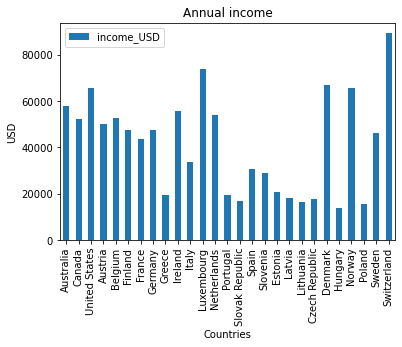

In [46]:
#exporting the annual income to bar graph
result_df.plot.bar(x='Country',y='income_USD')

plt.title('Annual income')
plt.xlabel('Countries')
plt.ylabel('USD')


Text(0, 0.5, 'Game price index')

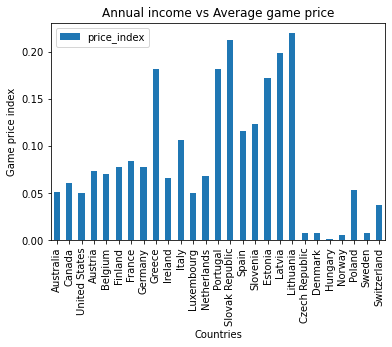

In [48]:
#exporting the game price index to bar graph
result_df.plot.bar(x='Country',y='price_index')

plt.title('Annual income vs Average game price')
plt.xlabel('Countries')
plt.ylabel('Game price index')

In [52]:
#exporting result to mongo
conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)

db = client.isthereanydeal_db
collection = db.priceindex

db.collection.insert_many(result_df.to_dict('records'))

In [53]:
result_df.to_csv('result.csv')